In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs

import xarray as xr
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from pathlib import Path
import netCDF4 as nc

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import dask

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [16]:
def contf_tmean(title, data, label, colormap, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max):
    proj = ccrs.PlateCarree(central_longitude=0.0) # Create Mollweide projections
    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection=proj)
    ax.set_extent([lon_min+5,lon_max-5,lat_min+5,lat_max-5])
    #plot = data.where((data.lat >= lat_min) & (data.lat <= lat_max) & (data.lon >= lon_min) & (data.lon <= lon_max)).plot(
    plot = data.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
    bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend='both',ticks=bounds, boundaries=bounds)
    cb.set_label(label=label, size=15, weight='bold')
    cb.ax.tick_params(labelsize=15)
    cb.ax.set_xticklabels(bounds,rotation=90)
    ax.coastlines(resolution='10m', lw=0.51)
    gl=ax.gridlines(draw_labels=True)
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 15}, {'fontsize': 15}
    ax.yaxis.tick_right() 
    ax.set_title(title, y=1.1, fontsize=20, weight='bold')
    _ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

# Analysis the Amazon climate with Reanalysis and observation data
## 1) Specific humidity
## 2) Vertical temperature
## 3) SST

# Specific Humidity (ERA5)
## Analysis the trend of specific humdity over the Amazon region over 1980-2021

In [2]:
file_era5 = nc.MFDataset('/scratch/m/m300948/ERA5/E5pl00_1D_average_133.nc')

In [3]:
q_era5 = file_era5.variables['var133']

In [6]:
q_era5=q_era5[:,:,0,0]

In [15]:
plev = file_era5_1.variables['plev'][:]
print(plev)

[   100.    200.    300.    500.    700.   1000.   2000.   3000.   5000.
   7000.  10000.  12500.  15000.  17500.  20000.  22500.  25000.  30000.
  35000.  40000.  45000.  50000.  55000.  60000.  65000.  70000.  75000.
  77500.  80000.  82500.  85000.  87500.  90000.  92500.  95000.  97500.
 100000.]


In [12]:
q_era5

array([[3.9378560e-06, 3.4497264e-06, 3.2919418e-06, ..., 1.6019478e-02,
        1.6802378e-02, 1.7787704e-02],
       [3.9180154e-06, 3.4435650e-06, 3.2921030e-06, ..., 1.5868749e-02,
        1.6598258e-02, 1.7589537e-02],
       [3.9248316e-06, 3.4213815e-06, 3.2771261e-06, ..., 1.5988396e-02,
        1.6752727e-02, 1.7683474e-02],
       ...,
       [3.8140438e-06, 3.3041788e-06, 3.1556904e-06, ..., 1.5842557e-02,
        1.6755503e-02, 1.8053632e-02],
       [3.7902432e-06, 3.3136182e-06, 3.1745560e-06, ..., 1.5821936e-02,
        1.6721431e-02, 1.8040769e-02],
       [3.7266782e-06, 3.2869220e-06, 3.1637940e-06, ..., 1.5690336e-02,
        1.6605731e-02, 1.7775157e-02]], dtype=float32)

In [ ]:
import datetime as DT
date=pd.date_range("1980-01-01", periods=15341)
q_era5['time'][:]=date[:]

In [15]:
q_era5_pbl = np.nanmean(q_era5[:,32:],axis=1)
mean = np.nanmean(q_era5_pbl,axis=0)

In [18]:
mean

0.015567719

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

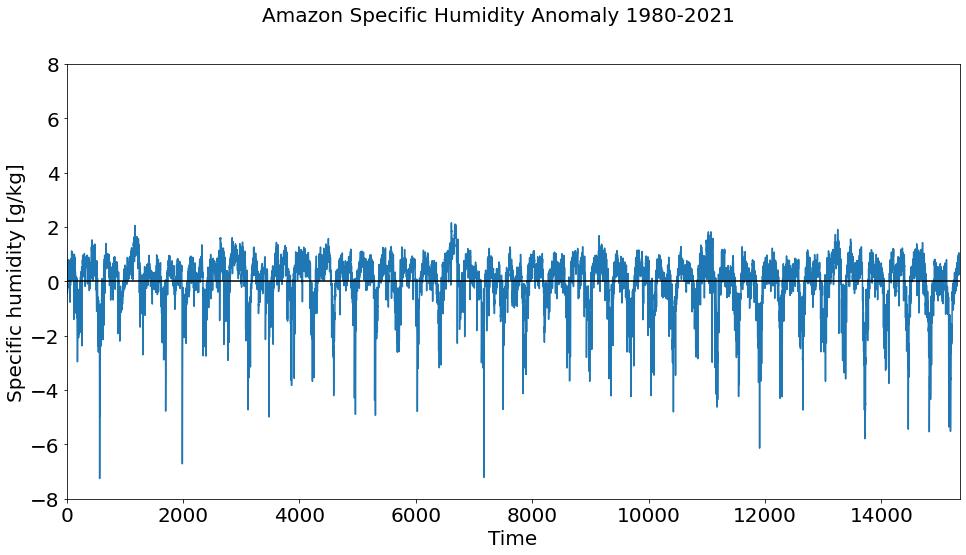

In [23]:
import datetime
fig = plt.figure(figsize=(16,8))
fig.suptitle('Amazon Specific Humidity Anomaly 1980-2021', size=20)
plt.plot((q_era5_pbl-mean)*1000)
plt.axhline(y=0, color='black',linewidth=1.5)
#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('Specific humidity [g/kg]',fontsize=20)
plt.xlabel('Time',fontsize=20)
plt.ylim(-8,8)
plt.xlim(0,15341)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Vertical temperature evaluation

In [ ]:
path_icon =Path('/scratch/m/m300948/test_04/')
glob_pattern = 'test_daily_pr_2020'
file_icon = sorted([str(f) for f in path_icon.glob(f'{glob_pattern}*.nc')])[:]

# SST (HadISST, ERA5)

### Load Reysnold 0.25x0.25

In [2]:
file_sst_rey = Path('/pool/data/ICDC/ocean/reynolds_sst/DATA/MONTHLY/2020')
glob_pattern = 'oisst-avhrr-v02r01__sst__monthly__UHAM-ICDC_2020'
file_rey = sorted([str(f) for f in file_sst_rey.glob(f'{glob_pattern}*.nc')])[:]

dset_sst_rey = xr.open_mfdataset(file_rey,parallel=True)['sst'].chunk({'lon':100,'time':-1})
dset_sst_rey

<xarray.DataArray 'sst' (time: 12, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(12, 720, 1440), dtype=float32, chunksize=(12, 720, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2020-12-15
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          Kelvin
    comment:        Monthly mean sea surface temperatures for all grid cells ...

### HadISST 1x1 (celcius -> Kelvin)

In [3]:
file_sst_had = '/pool/data/ICDC/ocean/hadisst1/DATA/HadISST_sst.nc'
dset_had = xr.open_dataset(file_sst_had)
var_names = ['sst']
dset_sst_had = dset_had[var_names]
sst_had=dset_sst_had['sst']

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sst' has multiple fill values {-1e+30, -1000.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
sst_had

<xarray.DataArray 'sst' (time: 1824, latitude: 180, longitude: 360)>
[118195200 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2021-1...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

### ICON 0.1x0.1 - INPUT

In [5]:
file_sst_in = '/work/mh0731/m300948/AMDEF/SST/modified_test_remapbil.nc'
dset_sst_in = xr.open_dataset(file_sst_in) # if it is ncfile
var_names = ['tosbcs']
subset_sst_in = dset_sst_in[var_names].persist()
sst_input = subset_sst_in['tosbcs']

In [6]:
sst_input

<xarray.DataArray 'tosbcs' (time: 12, lat: 1800, lon: 3600)>
[77760000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-16T12:00:00 ... 2020-12-16T12:00:00
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Constructed mid-month Sea Surface Temperature
    units:          degC
    cell_methods:   time: point
    cell_measures:  area: areacello

### ICON OUTPUT

In [7]:
# ts
path_sst_out =Path('/scratch/m/m300948/test_04/')
glob_pattern = 'test_daily_ts_2020'
file_sst_out = sorted([str(f) for f in path_sst_out.glob(f'{glob_pattern}*.nc')])[:59]
var = 'ts'
sst_output = xr.open_mfdataset(file_sst_out,parallel=True)[var].chunk({'time':24})
sst_output

<xarray.DataArray 'ts' (time: 59, lat: 600, lon: 3600)>
dask.array<rechunk-merge, shape=(59, 600, 3600), dtype=float32, chunksize=(24, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-21
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

### NextGEMS Cycle 2 0.1x0.1

In [8]:
path_ngc2_sst =Path('/scratch/m/m300948/nextgem_cyc2')
glob_pattern = 'ngc2002_daily_ts_2020'
file_ngc2 = sorted([str(f) for f in path_ngc2_sst.glob(f'{glob_pattern}*.nc')])[:]
var = 'ts'
sst_ngc2 = xr.open_mfdataset(file_ngc2,parallel=True)[var].chunk({'time':24})
sst_ngc2

<xarray.DataArray 'ts' (time: 59, lat: 600, lon: 3600)>
dask.array<rechunk-merge, shape=(59, 600, 3600), dtype=float32, chunksize=(24, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-23
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

## 1) Zonal mean comparison

In [68]:
sst_had_zonal

<xarray.DataArray 'sst' (time: 1824, latitude: 60)>
array([[19.376286, 20.237898, 20.959023, ..., 23.477669, 23.057487,
        22.63072 ],
       [18.435932, 19.362095, 20.143055, ..., 23.875326, 23.450052,
        22.998962],
       [18.951443, 19.935907, 20.793982, ..., 23.677416, 23.250154,
        22.81619 ],
       ...,
       [26.774017, 27.13059 , 27.418037, ..., 20.469866, 19.91457 ,
        19.369555],
       [24.571184, 25.093304, 25.566385, ..., 21.594044, 21.077005,
        20.576824],
       [22.213491, 22.846815, 23.432209, ..., 23.243402, 22.793694,
        22.379944]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2021-12...
  * latitude  (latitude) float32 29.5 28.5 27.5 26.5 ... -26.5 -27.5 -28.5 -29.5

In [57]:
sst_had_zonal=sst_had.sel(longitude=slice(90,180),latitude=slice(30,-30)).mean("longitude")
sst_rey_zonal=dset_sst_rey.sel(lon=slice(90,180),lat=slice(-30,30)).mean("lon")

In [138]:
# Use masking method to see over the ocean only 
sst_input_zonal=sst_input_mask.sel(lon=slice(90,180),lat=slice(-30,30)).mean("lon")
sst_output_zonal=sst_output_mask.sel(lon=slice(90,180),lat=slice(-30,30)).mean("lon")
sst_ngc2_zonal=sst_ngc2_mask.sel(lon=slice(90,180),lat=slice(-30,30)).mean("lon")

In [71]:
sst_had_zonal_mon=sst_had_zonal_mon+273

In [172]:
sst_had_zonal_mon=sst_had_zonal.resample(time='1M').mean("time")
sst_rey_zonal_mon=sst_rey_zonal.resample(time='1M').mean("time")
sst_input_zonal_mon=sst_input_zonal.resample(time='1M').mean("time")
sst_output_zonal_mon=sst_output_zonal.resample(time='1M').mean("time")
sst_ngc2_zonal_mon=sst_ngc2_zonal.resample(time='1M').mean("time")

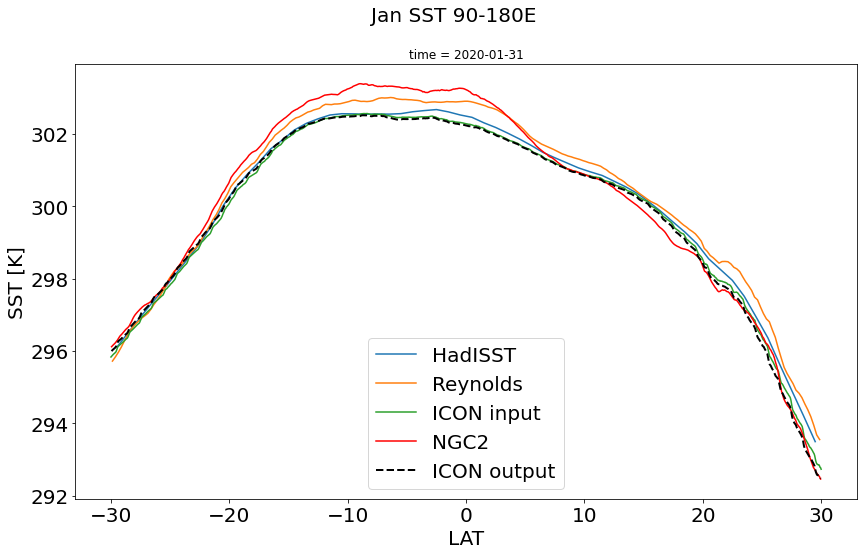

In [140]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('Jan SST 90-180E', size=20)

sst_had_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="HadISST")
sst_rey_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="Reynolds")
sst_input_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="ICON input", linewidth=1.5)
sst_ngc2_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="NGC2", c='red',linewidth=1.5)
sst_output_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="ICON output",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('SST [K]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
#plt.ylim(295,302)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

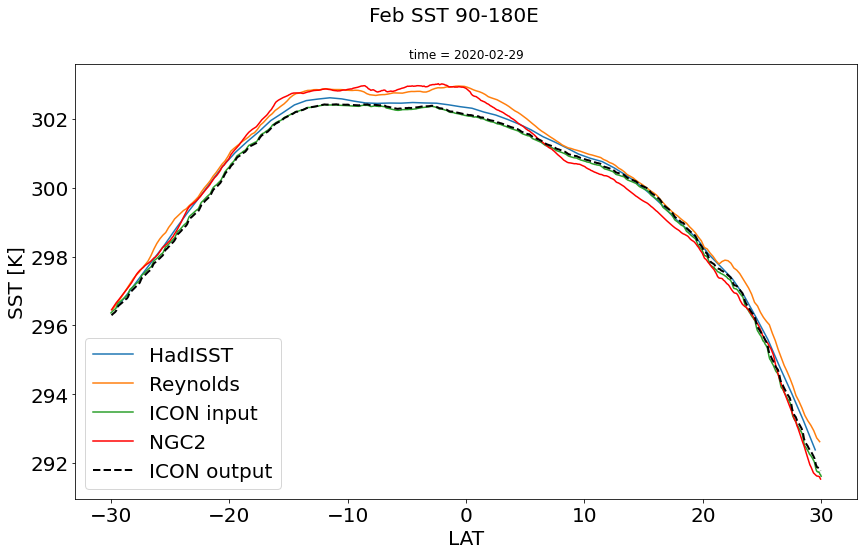

In [143]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('Feb SST 90-180E', size=20)

sst_had_zonal_mon.sel(time='2020-02-29T00:00:00.000000000').plot.line(label="HadISST")
sst_rey_zonal_mon.sel(time='2020-02-29T00:00:00.000000000').plot.line(label="Reynolds")
sst_input_zonal_mon.sel(time='2020-02-29T00:00:00.000000000').plot.line(label="ICON input")
sst_ngc2_zonal_mon.sel(time='2020-02-29T00:00:00.000000000').plot.line(label="NGC2",c='red')
sst_output_zonal_mon.sel(time='2020-02-29T00:00:00.000000000').plot.line(label="ICON output",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('SST [K]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
#plt.ylim(295,302)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [87]:
sst_output_zonal_mon

<xarray.DataArray 'ts' (time: 3, lat: 600)>
dask.array<stack, shape=(3, 600), dtype=float32, chunksize=(1, 600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-31 2020-02-29 2020-03-31
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

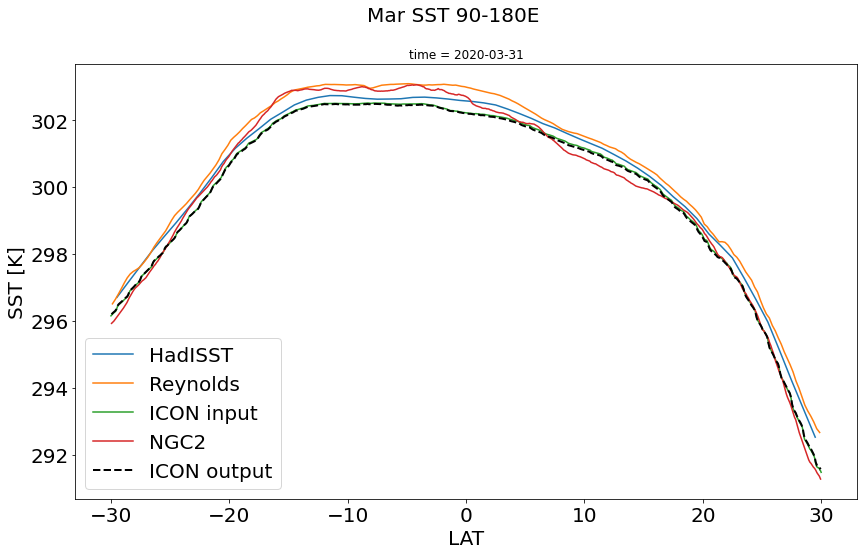

In [142]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('Mar SST 90-180E', size=20)

sst_had_zonal_mon.sel(time='2020-03-31T00:00:00.000000000').plot.line(label="HadISST")
sst_rey_zonal_mon.sel(time='2020-03-31T00:00:00.000000000').plot.line(label="Reynolds")
sst_input_zonal_mon.sel(time='2020-03-31T00:00:00.000000000').plot.line(label="ICON input")
sst_ngc2_zonal_mon.sel(time='2020-03-31T00:00:00.000000000').plot.line(label="NGC2")
sst_output_zonal_mon.isel(time=2).plot.line(label="ICON output",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('SST [K]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
#plt.ylim(295,302)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Time series of SST

## Masking SST

### Input for 5km masking process

In [12]:
# 5km for input SST [ICON 5km to 10km to match the IMERGE]
file_mask_5km = '/work/mh0731/m300948/dpp_0066/bc_land_phys_regrid.nc'
dset_5km = xr.open_dataset(file_mask_5km)
var_names = ['lai_clim']
dset_mask_5km = dset_5km[var_names].persist()
dset_mask_5km=dset_mask_5km.sel(lat=slice(-30,30))
dset_mask_5km=dset_mask_5km['lai_clim']
dset_mask_5km=dset_mask_5km.fillna(100)

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime

### output for 10km masking process

In [9]:
## Make this part as a module
# 10km for output SST [ICON 5km to 10km to match the IMERGE]
file_mask_10km = '/work/mh0731/m300948/dpp_0066/bc_land_phys_regrid_1x1.nc'
dset_nc_10km = nc.Dataset(file_mask_10km, mode='r')

# convert nc.dataset to xr.dataset
dset_xr_10km = xr.open_dataset(xr.backends.NetCDF4DataStore(dset_nc_10km))
dset_mask_10km=dset_xr_10km.sel(lat=slice(-30,30))
dset_mask_10km=dset_mask_10km['lai_clim']
dset_mask_10km=dset_mask_10km.fillna(100)

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime

In [40]:
# Only sst_input is for whole lat, so need to be selected over -30~30, others are already -30~30
file_sst_in = '/work/mh0731/m300948/AMDEF/SST/modified_test_remapbil.nc'
dset_sst_in = xr.open_dataset(file_sst_in) # if it is ncfile
var_names = ['tosbcs']
subset_sst_in = dset_sst_in[var_names].persist()
subset_sst_in=subset_sst_in.sel(lat=slice(-30,30))
sst_input=subset_sst_in['tosbcs']
#sst_input_mask=sst_input.where(dset_mask_10km.isel(time=0)==100,np.nan) # index problem -> numpy masking 

#### masking input file with remapbil input data -> for plotting diff contourf, need to change into numpy

In [76]:
import numpy as np
import numpy.ma as ma

sst_input_np = sst_input.values
dset_mask_10km_np = dset_mask_10km.values
sst_input_np_mask=np.ma.masked_where(dset_mask_10km_np!=100, sst_input_np)

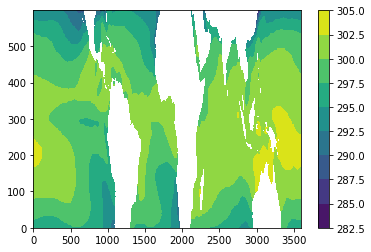

In [77]:
plt.contourf(sst_input_np_mask[0,:,:])
plt.colorbar()

In [11]:
# sst_output and ngc2 are 10km
sst_output_mask=sst_output.where(dset_mask_10km.isel(time=0)==100,np.nan)
sst_ngc2_mask=sst_ngc2.where(dset_mask_10km.isel(time=0)==100,np.nan)

In [81]:
sst_output_mask

<xarray.DataArray 'ts' (time: 59, lat: 600, lon: 3600)>
dask.array<where, shape=(59, 600, 3600), dtype=float32, chunksize=(24, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-21
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

In [82]:
sst_ngc2_mask

<xarray.DataArray 'ts' (time: 59, lat: 600, lon: 3600)>
dask.array<where, shape=(59, 600, 3600), dtype=float32, chunksize=(24, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-23
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

# SST difference plotting: should match the dimension

In [29]:
had_timavg_mon

<xarray.DataArray 'sst' (time: 3, latitude: 180, longitude: 360)>
[194400 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2020-01-16T12:00:00 ... 2020-03-16T12:00:00
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [24]:
sst_had = sst_had.reindex(latitude=list(reversed(sst_had.latitude)))

In [28]:
had_timavg_mon = sst_had.sel(time=slice('2020-01-01T12:00:00.000000000', '2020-03-23T12:00:00.000000000'))

In [17]:
input_timavg_mon = sst_input_mask.resample(time='1M').mean("time")
output_timavg_mon = sst_output_mask.resample(time='1M').mean("time")
ngc2_timavg_mon = sst_ngc2_mask.resample(time='1M').mean("time")

In [32]:
input_timavg_mon

<xarray.DataArray 'tosbcs' (time: 12, lat: 1201, lon: 7200)>
array([[[296.2747 , 296.2733 , 296.27246, ..., 296.27826, 296.27686,
         296.27576],
        [296.28928, 296.2899 , 296.28867, ..., 296.29593, 296.29138,
         296.2891 ],
        [296.3037 , 296.30344, 296.30356, ..., 296.3088 , 296.30658,
         296.30515],
        ...,
        [292.30383, 292.3042 , 292.30542, ..., 292.30927, 292.30667,
         292.3054 ],
        [292.28125, 292.28293, 292.282  , ..., 292.28906, 292.28287,
         292.28027],
        [292.25842, 292.257  , 292.25662, ..., 292.26135, 292.25998,
         292.2593 ]],

       [[296.89816, 296.8968 , 296.896  , ..., 296.9016 , 296.90027,
         296.8992 ],
        [296.91333, 296.91403, 296.9129 , ..., 296.91992, 296.91534,
         296.91306],
        [296.9283 , 296.92813, 296.9284 , ..., 296.93326, 296.93106,
         296.92972],
...
        [296.0247 , 296.02325, 296.02185, ..., 296.03503, 296.03082,
         296.02765],
        [296.00623, 296.006  , 296.0032 , ..., 296.0183 , 296.01126,
         296.00702],
        [295.98758, 295.98483, 295.98267, ..., 295.99542, 295.99265,
         295.9899 ]],

       [[295.04556, 295.0444 , 295.044  , ..., 295.04807, 295.04697,
         295.0463 ],
        [295.06256, 295.06372, 295.06287, ..., 295.0687 , 295.064  ,
         295.06192],
        [295.07935, 295.0795 , 295.0803 , ..., 295.08377, 295.08173,
         295.0806 ],
        ...,
        [294.24432, 294.2446 , 294.24564, ..., 294.24963, 294.24713,
         294.24585],
        [294.22345, 294.22495, 294.22403, ..., 294.23083, 294.22504,
         294.22256],
        [294.20233, 294.20096, 294.2006 , ..., 294.20508, 294.2038 ,
         294.20316]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-31 2020-02-29 ... 2020-12-31
  * lon      (lon) float64 -179.9 -179.9 -179.8 -179.8 ... 179.9 180.0 180.0
  * lat      (lat) float64 -30.0 -29.95 -29.9 -29.85 ... 29.85 29.9 29.95 30.0

In [33]:
output_timavg_mon

<xarray.DataArray 'ts' (time: 3, lat: 600, lon: 3600)>
dask.array<stack, shape=(3, 600, 3600), dtype=float32, chunksize=(1, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-31 2020-02-29 2020-03-31
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

In [30]:
ngc2_timavg_mon

<xarray.DataArray 'ts' (time: 3, lat: 600, lon: 3600)>
dask.array<stack, shape=(3, 600, 3600), dtype=float32, chunksize=(1, 600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-31 2020-02-29 2020-03-31
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95

## OUTPUT-NGC2 SST DIFFERENCE

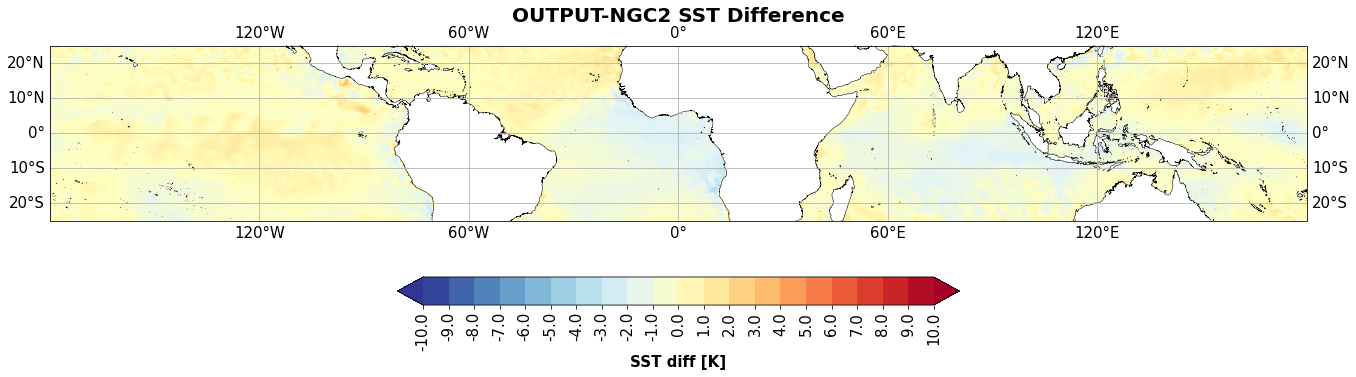

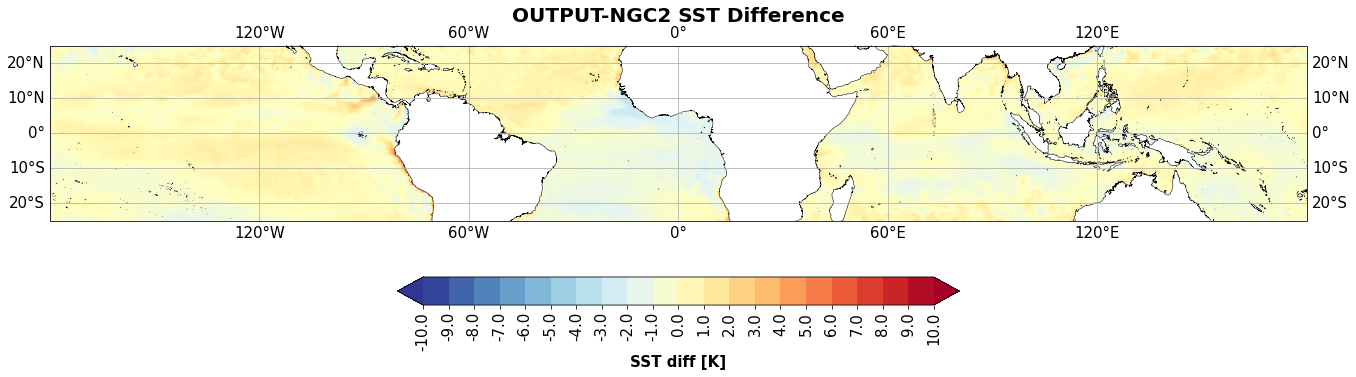

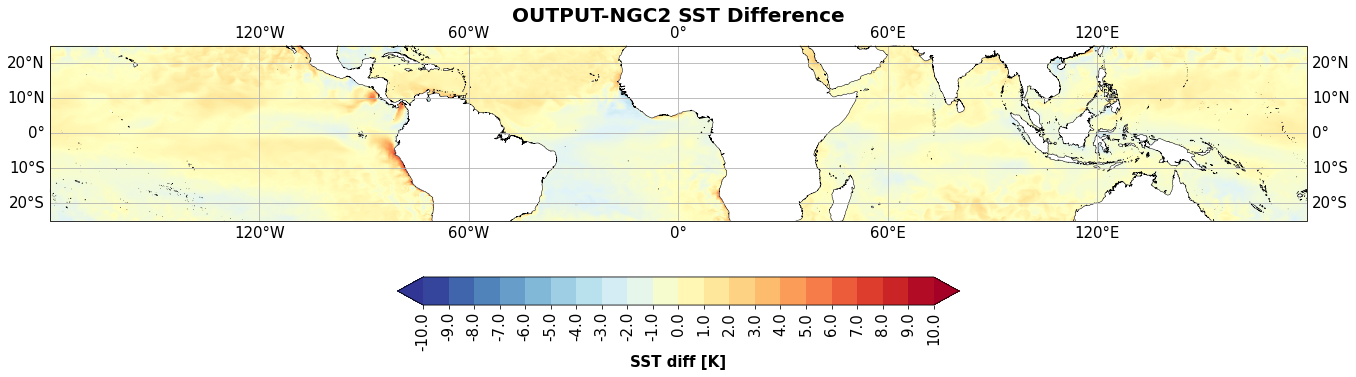

In [34]:
time_idx = ['2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000']
for i in range(3):   
    contf_tmean(f'OUTPUT-NGC2 SST Difference',output_timavg_mon.sel(time=time_idx[i])-ngc2_timavg_mon.sel(time=time_idx[i]),'SST diff [K]','RdYlBu_r',-10, 10, 21,-30,30,-180,180)

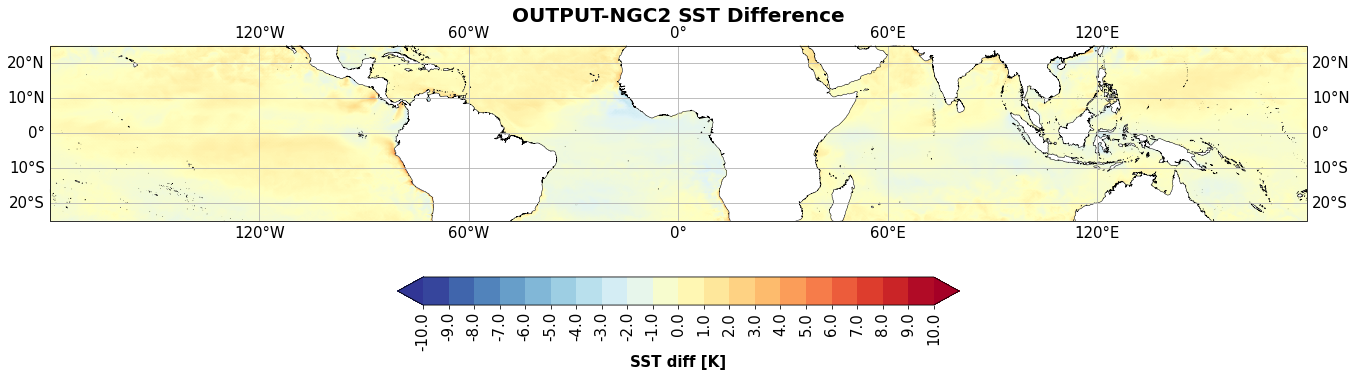

In [36]:
min_out_ngc2_sst = output_timavg_mon-ngc2_timavg_mon
totoal_min_out_ngc2_sst = min_out_ngc2_sst.mean("time")
contf_tmean(f'OUTPUT-NGC2 SST Difference',totoal_min_out_ngc2_sst,'SST diff [K]','RdYlBu_r',-10, 10, 21,-30,30,-180,180)

## INPUT-OUTPUT DIFFERENCE PLOT

In [57]:
def contf_diff(title, data, colormap, varmin, varmax, space):
    dset_icon = xr.open_dataset('/scratch/m/m300948/test_04/test_daily_tas_20200120_0.1_0.1.nc')['tas']

    lats = dset_icon.lat
    lons = dset_icon.lon

    fig = plt.figure(figsize=[18,12],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-175,175,-30,30])
    ax.coastlines('50m',linewidth=0.8)
    grid_lines = ax.gridlines(draw_labels=True)
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER

    m = ax.pcolormesh(lons,lats,data,cmap=colormap,vmin=varmin,vmax=varmax,transform=ccrs.PlateCarree())
    cbar = plt.colorbar(m,fraction=0.01, pad=0.04,extend='both')
    cbar_ticks = np.linspace(varmin, varmax, num=space)
    cbar.set_ticks(cbar_ticks)
    ax.set_title(title,y=1.1,fontsize=20,fontweight='bold')
    plt.show()


In [54]:
output_timavg_mon_np = output_timavg_mon.values
ngc2_timavg_mon_np = ngc2_timavg_mon.values
print(np.shape(output_timavg_mon_np))
print(np.shape(ngc2_timavg_mon_np))
print(np.shape(sst_input_np_mask))

(3, 600, 3600)
(3, 600, 3600)
(12, 600, 3600)


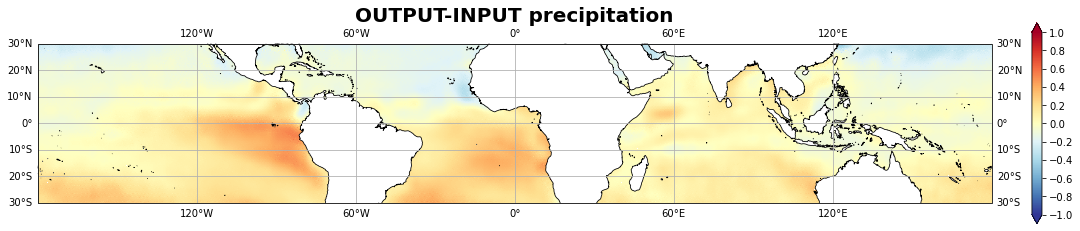

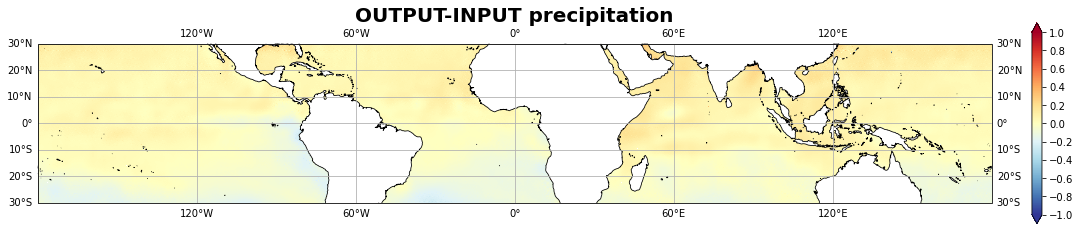

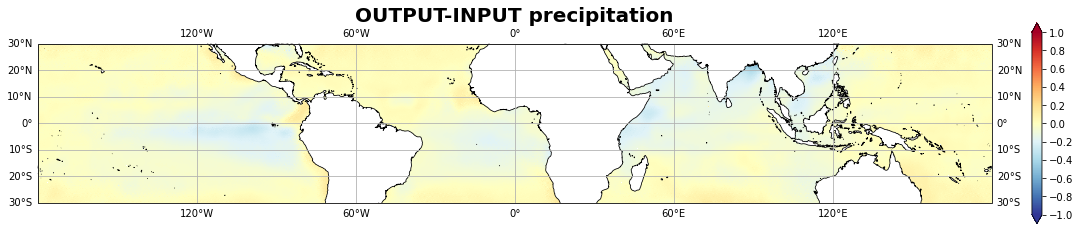

In [97]:
# difference btw ngc2 and icon
for i in range(3):
    contf_diff(f'OUTPUT-INPUT SST',output_timavg_mon_np[i,:,:]-sst_input_np_mask[i,:,:],'RdYlBu_r', -1, 1, 11)

(3, 600, 3600)


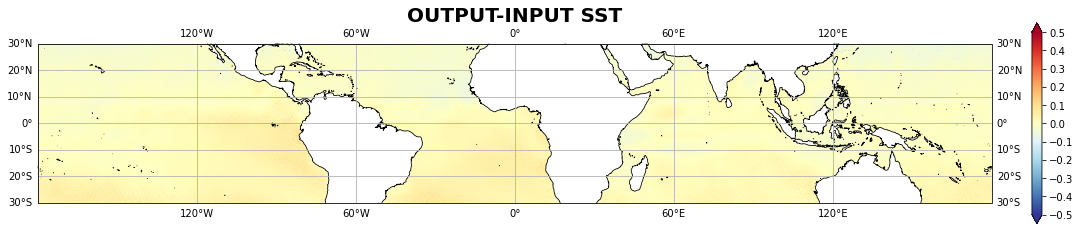

In [105]:
a1=output_timavg_mon_np[:,:,:]-sst_input_np_mask[:3,:,:]
print(np.shape(a1))
a1_sum = np.nanmean(a1,axis=0)
contf_diff(f'OUTPUT-INPUT SST',a1_sum,'RdYlBu_r', -0.5, 0.5, 11)

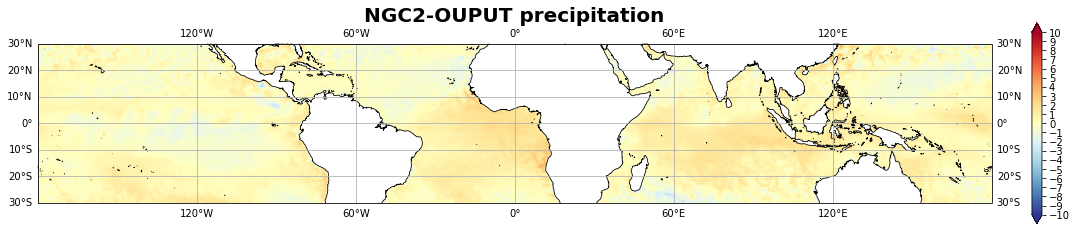

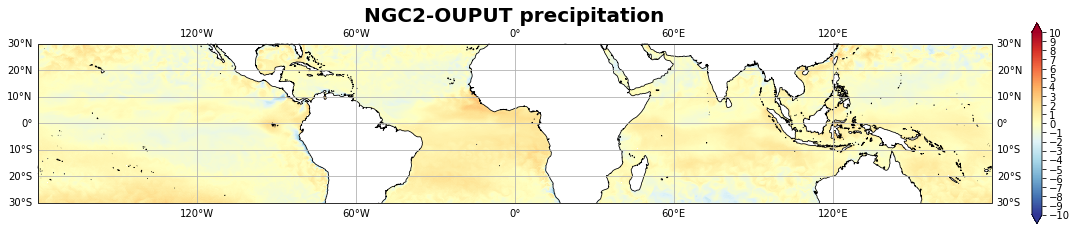

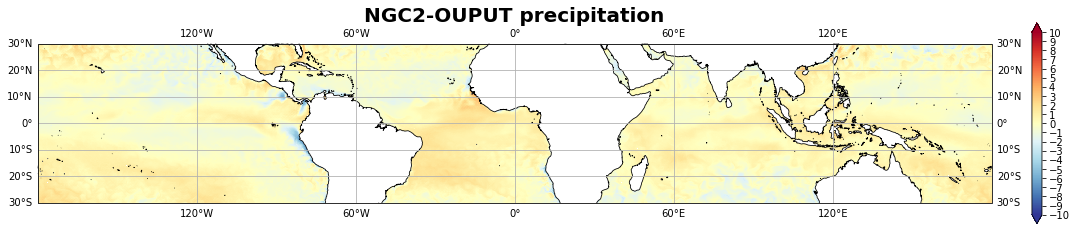

In [104]:
# difference btw ngc2 and icon
for i in range(3):
    contf_diff(f'NGC2-OUPUT SST',ngc2_timavg_mon_np[i,:,:]-output_timavg_mon_np[i,:,:],'RdYlBu_r', -10, 10, 21)

(3, 600, 3600)


/tmp/ipykernel_3115727/576485954.py:3: RuntimeWarning: Mean of empty slice
  a2_sum = np.nanmean(a2,axis=0)


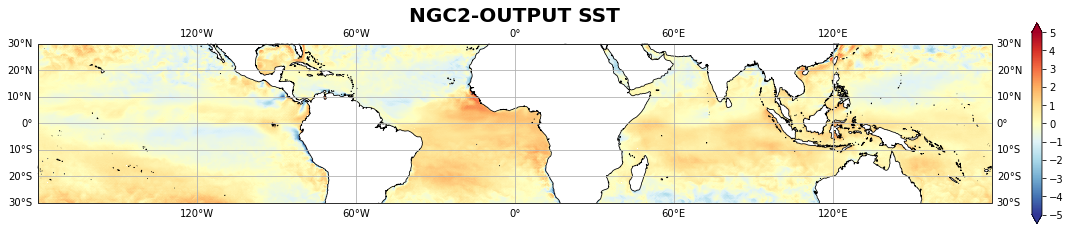

In [106]:
a2 = ngc2_timavg_mon_np[:,:,:]-output_timavg_mon_np[:,:,:]
print(np.shape(a2))
a2_sum = np.nanmean(a2,axis=0)
contf_diff(f'NGC2-OUTPUT SST',a2_sum,'RdYlBu_r', -5, 5, 11)

# SST timeseries for each data

In [127]:
sst_input_zonal=sst_input_mask.sel(lon=slice(90,180),lat=slice(-10,10)).mean(("lon","lat"))
sst_output_zonal=sst_output_mask.sel(lon=slice(90,180),lat=slice(-10,10)).mean(("lon","lat"))
sst_ngc2_zonal=sst_ngc2_mask.sel(lon=slice(90,180),lat=slice(-10,10)).mean(("lon","lat"))

In [128]:
sst_input_zonal

<xarray.DataArray 'tosbcs' (time: 12)>
array([301.9969 , 301.87088, 302.09616, 302.48444, 302.64557, 302.41647,
       302.06097, 301.86078, 302.0157 , 302.25833, 302.4977 , 302.31104],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-16T12:00:00 ... 2020-12-16T12:00:00

In [122]:
# Make input data with constant values [-30~30]
sstin_90180_spaiavg_1 = np.full(12,300.22025)
sstin_90180_spaiavg_2 = np.full(29,300.12415)
sstin_90180_spaiavg_3 = np.full(22,300.30246)
sstin_90180_spaiavg_final = np.concatenate((sstin_90180_spaiavg_1, sstin_90180_spaiavg_2, sstin_90180_spaiavg_3))

In [129]:
# Make input data with constant values [-30~30]
sstin_90180_spaiavg_1 = np.full(12,301.9969)
sstin_90180_spaiavg_2 = np.full(29,301.87088)
sstin_90180_spaiavg_3 = np.full(22,302.09616)
sstin_90180_spaiavg_final = np.concatenate((sstin_90180_spaiavg_1, sstin_90180_spaiavg_2, sstin_90180_spaiavg_3))

In [130]:
time = pd.date_range("2020-01-20", periods=63)
da = xr.DataArray(
     data=sstin_90180_spaiavg_final,
     dims=["time"],
     coords=dict(
         time=time,
     ),
     attrs=dict(
         description="SST",
         units="K",
     ),
 )

In [131]:
da

<xarray.DataArray (time: 63)>
array([301.9969 , 301.9969 , 301.9969 , 301.9969 , 301.9969 , 301.9969 ,
       301.9969 , 301.9969 , 301.9969 , 301.9969 , 301.9969 , 301.9969 ,
       301.87088, 301.87088, 301.87088, 301.87088, 301.87088, 301.87088,
       301.87088, 301.87088, 301.87088, 301.87088, 301.87088, 301.87088,
       301.87088, 301.87088, 301.87088, 301.87088, 301.87088, 301.87088,
       301.87088, 301.87088, 301.87088, 301.87088, 301.87088, 301.87088,
       301.87088, 301.87088, 301.87088, 301.87088, 301.87088, 302.09616,
       302.09616, 302.09616, 302.09616, 302.09616, 302.09616, 302.09616,
       302.09616, 302.09616, 302.09616, 302.09616, 302.09616, 302.09616,
       302.09616, 302.09616, 302.09616, 302.09616, 302.09616, 302.09616,
       302.09616, 302.09616, 302.09616])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-22
Attributes:
    description:  SST
    units:        K

In [117]:
sst_output_zonal

<xarray.DataArray 'ts' (time: 59)>
dask.array<mean_agg-aggregate, shape=(59,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-21

In [118]:
sst_ngc2_zonal

<xarray.DataArray 'ts' (time: 59)>
dask.array<mean_agg-aggregate, shape=(59,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-03-23

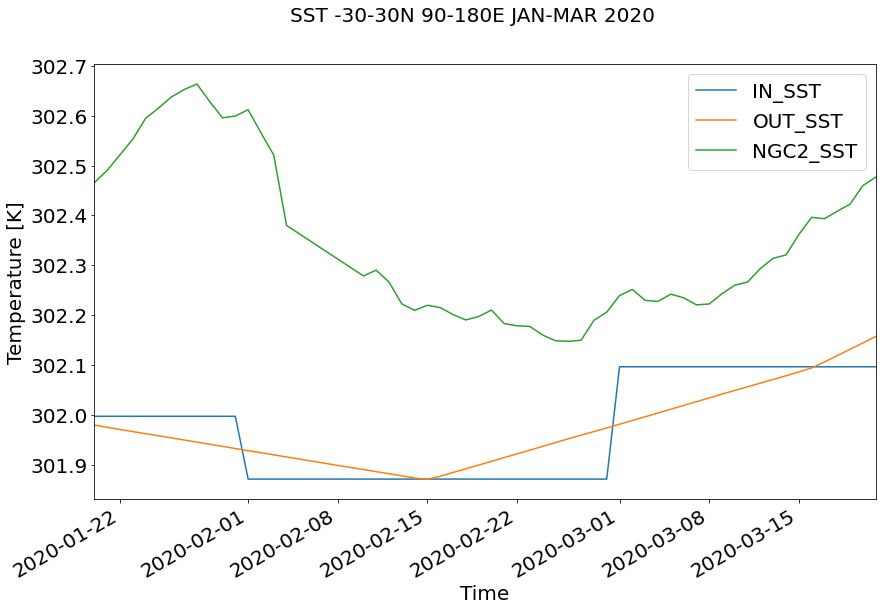

In [132]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('SST -30-30N 90-180E JAN-MAR 2020', size=20)
da.plot.line(label="IN_SST")
sst_output_zonal.plot.line(label="OUT_SST")
sst_ngc2_zonal.plot.line(label="NGC2_SST")

plt.ylabel('Temperature [K]',fontsize=20)
plt.xlabel('Time',fontsize=20)
#plt.ylim(298,301)
plt.xlim([datetime.date(2020, 1, 20),datetime.date(2020, 3, 21)])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [180]:
da = xr.DataArray(
   np.array([1, 2, 3, 1, 2, np.nan]),
    dims="time",
     coords=dict(
         time=("time", pd.date_range("01-01-2001", freq="M", periods=6)),
         labels=("time", np.array(["a", "b", "c", "c", "b", "a"])),
     ),
 )
da


<xarray.DataArray (time: 6)>
array([ 1.,  2.,  3.,  1.,  2., nan])
Coordinates:
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2001-06-30
    labels   (time) <U1 'a' 'b' 'c' 'c' 'b' 'a'

In [185]:
da.mean(skipna=False)

<xarray.DataArray ()>
array(nan)